<a href="https://colab.research.google.com/github/lune07/Expense-Categorization/blob/main/Categorization_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Expense Categorization using MiniLM Embeddings, SVM, XGBoost & Ensemble

## 1. Project Overview

Implementing an **expense categorization system** that predicts categories such as `Food`, `Transport`, `Shopping`, etc. from raw transaction descriptions (e.g., `"Uber ride to office"`, `"Starbucks latte"`).

The pipeline uses:

- **MiniLM Sentence Embeddings** (`all-MiniLM-L6-v2`) from `sentence-transformers`
- **SVM (RBF kernel)** with hyperparameter tuning
- **XGBoost** classifier
- **Ensemble model** combining SVM + XGBoost probabilities
- **Model evaluation** (accuracy, classification report, confusion matrix)
- **Error / mistake analysis** to inspect misclassified examples


In [67]:
# 2. Install dependencies
!pip install -q sentence-transformers xgboost

## 3. Imports & Configuration

In [68]:
import pandas as pd
import numpy as np

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

import matplotlib.pyplot as plt

DATA_PATH = "/content/expense_data.csv"
RANDOM_STATE = 42

## 4. Load & Clean Dataset

In [69]:
# Load dataset
df = pd.read_csv(DATA_PATH)

# Basic schema check
assert "Description" in df.columns and "Category" in df.columns,"CSV must contain 'Description' and 'Category' columns."

# Drop missing values
df = df.dropna(subset=["Description", "Category"]).reset_index(drop=True)

print("Original category distribution:")
print(df["Category"].value_counts())

# Remove extremely rare categories (< 2 samples)
counts = df["Category"].value_counts()
rare = counts[counts < 2].index
print("\nDropping rare categories:", list(rare))

df = df[~df["Category"].isin(rare)].reset_index(drop=True)

print("\nUpdated category distribution:")
print(df["Category"].value_counts())

Original category distribution:
Category
Food                     16
Transport                12
Entertainment            11
Health & Fitness          9
Electronics               6
Household                 6
Travel                    6
Utilities                 5
Insurance                 5
Personal Care             5
Business Expenses         5
Education                 5
Clothing                  4
Gifts                     4
Software                  3
Books                     3
Rent                      2
Charity                   2
Professional Services     2
Pets                      2
Shopping                  1
Hobbies                   1
Debt Repayment            1
Marketing                 1
Name: count, dtype: int64

Dropping rare categories: ['Shopping', 'Hobbies', 'Debt Repayment', 'Marketing']

Updated category distribution:
Category
Food                     16
Transport                12
Entertainment            11
Health & Fitness          9
Household                 

In [70]:
import random

def augment_description(desc):
    patterns = [
        f"{desc}",
        f"Expense: {desc}",
        f"Payment for {desc}",
        f"{desc} made today",
        f"{desc} transaction",
        f"{desc} purchase",
        f"{desc} recorded",
        f"Paid for {desc}",
        f"Processed: {desc}",
    ]
    return random.choice(patterns)

# Apply augmentation: doubles dataset size
augmented_rows = []

for i, row in df.iterrows():
    new_desc = augment_description(row["Description"])
    augmented_rows.append([new_desc, row["Category"]])

# Convert to DataFrame
aug_df = pd.DataFrame(augmented_rows, columns=["Description", "Category"])

# Append augmented data
df = pd.concat([df, aug_df], ignore_index=True)
print("Dataset size after augmentation:", df.shape)


Dataset size after augmentation: (226, 2)


## 5. Label Encoding & Train/Test Split

In [71]:
# Encode string labels -> numeric ids
le = LabelEncoder()
df["label"] = le.fit_transform(df["Category"])

X_text = df["Description"].astype(str).tolist()
y = df["label"].values

# Stratified train-test split to preserve label distribution
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Train size: {len(X_train_text)}, Test size: {len(X_test_text)}")
print("Classes:", list(le.classes_))

# Labels actually present in the test set
test_labels = np.unique(y_test)
test_label_names = le.inverse_transform(test_labels)

Train size: 180, Test size: 46
Classes: ['Books', 'Business Expenses', 'Charity', 'Clothing', 'Education', 'Electronics', 'Entertainment', 'Food', 'Gifts', 'Health & Fitness', 'Household', 'Insurance', 'Personal Care', 'Pets', 'Professional Services', 'Rent', 'Software', 'Transport', 'Travel', 'Utilities']


## 6. MiniLM Embeddings

In [72]:
# Load MiniLM sentence embedding model
print("Loading MiniLM encoder...")
encoder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Encode train & test descriptions into dense vectors
print("\nEncoding training descriptions...")
X_train_emb = encoder.encode(
    X_train_text,
    batch_size=32,
    convert_to_numpy=True,
    show_progress_bar=True
)

print("\nEncoding test descriptions...")
X_test_emb = encoder.encode(
    X_test_text,
    batch_size=32,
    convert_to_numpy=True,
    show_progress_bar=True
)

print("\nTrain embedding shape:", X_train_emb.shape)
print("Test embedding shape:", X_test_emb.shape)

Loading MiniLM encoder...

Encoding training descriptions...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]


Encoding test descriptions...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]


Train embedding shape: (180, 384)
Test embedding shape: (46, 384)


## 7. Feature Scaling for SVM

In [73]:
# SVM is sensitive to feature scale, so we standardize embeddings
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_emb)
X_test_scaled = scaler.transform(X_test_emb)

## 8. Train SVM with Hyperparameter Tuning (GridSearchCV)

In [74]:
svm = SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE)

param_grid = {
    "C": [0.1, 0.5, 1, 3, 5, 10],
    "gamma": ["scale", "auto", 0.1, 0.01, 0.001]
}

print("Running GridSearchCV for SVM...")

grid_svm = GridSearchCV(
    svm,
    param_grid,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_svm.fit(X_train_scaled, y_train)

best_svm = grid_svm.best_estimator_
print("\nBest SVM parameters:", grid_svm.best_params_)

Running GridSearchCV for SVM...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Best SVM parameters: {'C': 5, 'gamma': 0.001}


In [75]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    best_svm,
    X_train_scaled,
    y_train,
    cv=5,
    scoring='accuracy'
)

print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean() * 100)
print("Std deviation:", cv_scores.std() * 100)


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation scores: [0.83333333 0.91666667 0.94444444 0.94444444 0.94444444]
Mean CV accuracy: 91.66666666666667
Std deviation: 4.30331482911935


## 9. Train XGBoost Classifier

In [76]:
print("Training XGBoost classifier")

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    random_state=RANDOM_STATE
)

xgb.fit(X_train_emb, y_train)

Training XGBoost classifier


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [77]:
print("\n XGBOOST CROSS-VALIDATION")

xgb_cv_scores = cross_val_score(
    xgb,
    X_train_emb,
    y_train,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

print("XGBoost CV scores:", xgb_cv_scores)
print("XGBoost Mean CV Accuracy:", round(xgb_cv_scores.mean() * 100, 2), "%")
print("XGBoost Std Dev:", round(xgb_cv_scores.std() * 100, 2), "%")



 XGBOOST CROSS-VALIDATION


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


XGBoost CV scores: [0.75       0.77777778 0.83333333 0.91666667 0.83333333]
XGBoost Mean CV Accuracy: 82.22 %
XGBoost Std Dev: 5.72 %


## 10. Model Evaluation: SVM, XGBoost, and Ensemble

In [78]:
# SVM Evaluation
y_pred_svm = best_svm.predict(X_test_scaled)
acc_svm = accuracy_score(y_test, y_pred_svm)

print("\n SVM PERFORMANCE ")
print(f"Accuracy: {acc_svm:.4f}")
print(classification_report(
    y_test,
    y_pred_svm,
    labels=test_labels,
    target_names=test_label_names
))

# XGBoost Evaluation
y_pred_xgb = xgb.predict(X_test_emb)
acc_xgb = accuracy_score(y_test, y_pred_xgb)

print("\n XGBOOST PERFORMANCE ")
print(f"Accuracy: {acc_xgb:.4f}")
print(classification_report(
    y_test,
    y_pred_xgb,
    labels=test_labels,
    target_names=test_label_names
))

# Ensemble (Average Probabilities)
proba_svm = best_svm.predict_proba(X_test_scaled)
proba_xgb = xgb.predict_proba(X_test_emb)

proba_ensemble = (proba_svm + proba_xgb) / 2.0
y_pred_ens = np.argmax(proba_ensemble, axis=1)
acc_ens = accuracy_score(y_test, y_pred_ens)

print("\n ENSEMBLE (SVM + XGBoost) PERFORMANCE ")
print(f"Accuracy: {acc_ens:.4f}")
print(classification_report(
    y_test,
    y_pred_ens,
    labels=test_labels,
    target_names=test_label_names
))


 SVM PERFORMANCE 
Accuracy: 1.0000
                       precision    recall  f1-score   support

                Books       1.00      1.00      1.00         1
    Business Expenses       1.00      1.00      1.00         2
              Charity       1.00      1.00      1.00         1
             Clothing       1.00      1.00      1.00         2
            Education       1.00      1.00      1.00         2
          Electronics       1.00      1.00      1.00         2
        Entertainment       1.00      1.00      1.00         4
                 Food       1.00      1.00      1.00         7
                Gifts       1.00      1.00      1.00         2
     Health & Fitness       1.00      1.00      1.00         4
            Household       1.00      1.00      1.00         2
            Insurance       1.00      1.00      1.00         2
        Personal Care       1.00      1.00      1.00         2
                 Pets       1.00      1.00      1.00         1
Professional Servi

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

## 11. Confusion Matrix (Ensemble)

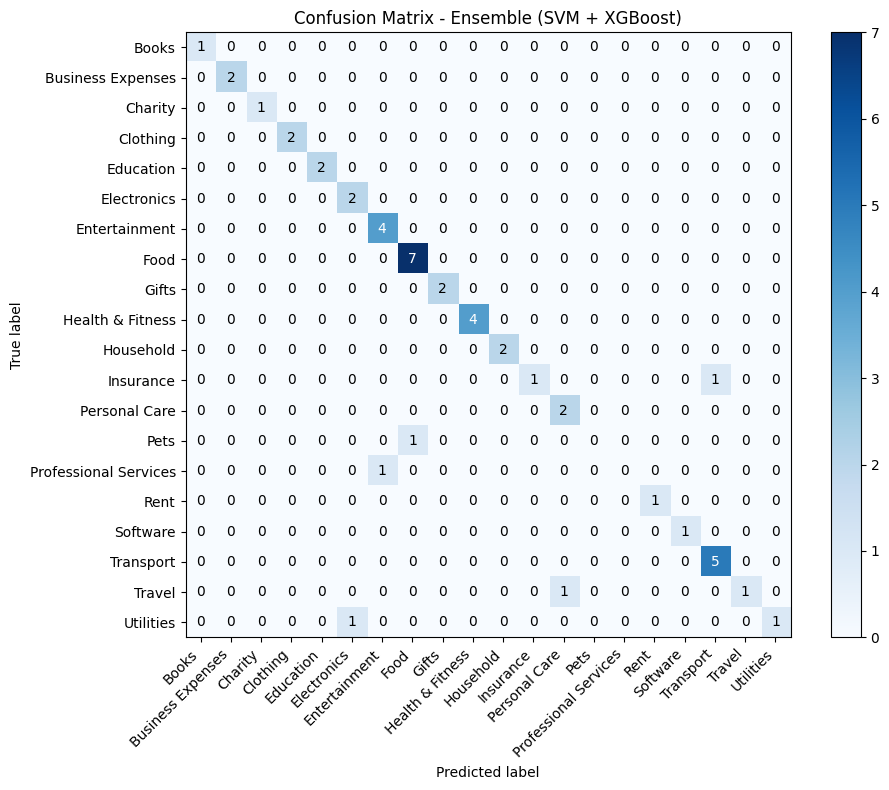

In [79]:
cm = confusion_matrix(y_test, y_pred_ens, labels=test_labels)

plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix - Ensemble (SVM + XGBoost)")
plt.colorbar()

tick_marks = np.arange(len(test_label_names))
plt.xticks(tick_marks, test_label_names, rotation=45, ha="right")
plt.yticks(tick_marks, test_label_names)

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, cm[i, j],
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

In [80]:
print("SVM Accuracy (%):", round(acc_svm * 100, 2))
print("XGBoost Accuracy (%):", round(acc_xgb * 100, 2))
print("Ensemble Accuracy (%):", round(acc_ens * 100, 2))


SVM Accuracy (%): 100.0
XGBoost Accuracy (%): 86.96
Ensemble Accuracy (%): 89.13


In [81]:
error_rate = 1 - acc_ens
print("Error Rate:", round(error_rate * 100, 2), "%")


Error Rate: 10.87 %


## 12. Mistake Analysis

In [82]:
results_df = pd.DataFrame({
    "Description": X_test_text,
    "True_label_id": y_test,
    "Pred_svm_id": y_pred_svm,
    "Pred_xgb_id": y_pred_xgb,
    "Pred_ens_id": y_pred_ens
})

results_df["True_label"] = le.inverse_transform(results_df["True_label_id"])
results_df["Pred_svm"] = le.inverse_transform(results_df["Pred_svm_id"])
results_df["Pred_xgb"] = le.inverse_transform(results_df["Pred_xgb_id"])
results_df["Pred_ens"] = le.inverse_transform(results_df["Pred_ens_id"])

mistakes = results_df[results_df["True_label"] != results_df["Pred_ens"]]

print("Number of misclassified examples (ensemble):", len(mistakes))
print("\nSample misclassifications:")
mistakes.head(15)[[
    "Description", "True_label", "Pred_svm", "Pred_xgb", "Pred_ens"
]]

Number of misclassified examples (ensemble): 5

Sample misclassifications:


,Description,True_label,Pred_svm,Pred_xgb,Pred_ens
5,Processed: Insurance for personal vehicle,Insurance,Insurance,Transport,Transport
12,Weekend trip to the beach recorded,Travel,Travel,Personal Care,Personal Care
16,Processed: Cost of attending a networking event,Professional Services,Professional Services,Entertainment,Entertainment
23,Home internet service,Utilities,Utilities,Electronics,Electronics
44,Expense: Pet food and supplies,Pets,Pets,Food,Food


## 13. Helper Function for Single Prediction

In [83]:
def predict_category(description: str):
    """Predict expense category for a single description using the ensemble model."""
    emb = encoder.encode([description], convert_to_numpy=True)
    emb_scaled = scaler.transform(emb)

    proba_svm = best_svm.predict_proba(emb_scaled)
    proba_xgb = xgb.predict_proba(emb)
    proba_ensemble = (proba_svm + proba_xgb) / 2.0

    label_id = np.argmax(proba_ensemble, axis=1)[0]
    return le.inverse_transform([label_id])[0]

# Example
example = "Starbucks coffee and sandwich"
print("Description:", example)
print("Predicted category:", predict_category(example))

Description: Starbucks coffee and sandwich
Predicted category: Food


In [84]:
print(" MISCLASSIFIED EXAMPLES RECHECK")
for i, row in mistakes.head(10).iterrows():
    print("\nOriginal:", row["Description"])
    print("True:", row["True_label"])
    print("Predicted:", predict_category(row["Description"]))


 MISCLASSIFIED EXAMPLES RECHECK

Original: Processed: Insurance for personal vehicle
True: Insurance
Predicted: Transport

Original: Weekend trip to the beach recorded
True: Travel
Predicted: Personal Care

Original: Processed: Cost of attending a networking event
True: Professional Services
Predicted: Entertainment

Original: Home internet service
True: Utilities
Predicted: Electronics

Original: Expense: Pet food and supplies
True: Pets
Predicted: Food


In [85]:
test_samples = [
    "Uber ride to college",
    "Starbucks cold brew and bagel",
    "New bedsheet purchased from Amazon",
    "Rent payment for February",
    "Electricity bill for the month",
    "Groceries from Walmart",
    "Dinner at McDonald's",
    "Flight tickets to Chicago",
    "Phone recharge payment",
    "Netflix monthly subscription",
    "Medical bill for consultation",
    "Bought a hoodie from Zara",
    "Recharge for metro card",
]

print(" MODEL TESTING ")
for t in test_samples:
    print(f"\nDescription: {t}")
    print("Predicted:", predict_category(t))


 MODEL TESTING 

Description: Uber ride to college
Predicted: Transport

Description: Starbucks cold brew and bagel
Predicted: Food

Description: New bedsheet purchased from Amazon
Predicted: Travel

Description: Rent payment for February
Predicted: Rent

Description: Electricity bill for the month
Predicted: Utilities

Description: Groceries from Walmart
Predicted: Food

Description: Dinner at McDonald's
Predicted: Food

Description: Flight tickets to Chicago
Predicted: Entertainment

Description: Phone recharge payment
Predicted: Entertainment

Description: Netflix monthly subscription
Predicted: Entertainment

Description: Medical bill for consultation
Predicted: Education

Description: Bought a hoodie from Zara
Predicted: Electronics

Description: Recharge for metro card
Predicted: Transport


In [86]:
stress_tests = [
    "Paid online",
    "Card swipe",
    "Unknown debit transaction",
    "Something from Amazon",
    "Snacks and random stuff",
    "Misc payment",
    "Payment via UPI",
    "Gave money to friend",
]

print("\n STRESS TEST RESULTS")
for s in stress_tests:
    print(f"\nDescription: {s}")
    print("Predicted:", predict_category(s))



 STRESS TEST RESULTS

Description: Paid online
Predicted: Entertainment

Description: Card swipe
Predicted: Personal Care

Description: Unknown debit transaction
Predicted: Electronics

Description: Something from Amazon
Predicted: Electronics

Description: Snacks and random stuff
Predicted: Food

Description: Misc payment
Predicted: Entertainment

Description: Payment via UPI
Predicted: Clothing

Description: Gave money to friend
Predicted: Gifts
